## Notebook for VMS: 
* plot acceleration
* calculate and plot displacements, and compare to displacement requirements
* calculate and plot PSD of displacements
* convert displacements in image quality degrations, and compare to requirements.

To do:
* analyze results from the rubber band experiment (https://jira.lsstcorp.org/browse/LVV-9482), to determine the noise frequency, and adjust our `cutoff_frequency` accordingly?
* get simultaneous IMS and VMS data. The IMS requirements state that `The IMS sampling rate shall be at least 5 Hz`. So if the IMS PSD is very different from VMS below 5Hz, then the VMS PSD below 5Hz is invalidated, therefore should be cut off (??)

In [1]:
import pandas as pd
import numpy as np
from scipy import fftpack
%matplotlib inline
import matplotlib.pyplot as plt
#plt.rcParams['figure.figsize'] = (13, 8)

In [2]:
dt = 0.001 #justified below in the notebook
buffer_size = 15 #in seconds
cutoff_frequency = 5 #10 # Hz

In [3]:
d = pd.read_csv('M1M3_2021-05-21T19-29-30.csv')

In [4]:
d

,# timestamp,1 X,1 Y,1 Z,2 X,2 Y,2 Z,3 X,3 Y,3 Z
0,1.621625e+09,-0.000767,-0.000569,-0.000908,0.000901,0.001121,0.000874,0.002969,0.002888,0.002871
1,1.621625e+09,-0.000945,-0.000740,-0.001114,0.002941,0.003125,0.002859,0.001022,0.000932,0.000937
2,1.621625e+09,-0.001193,-0.000993,-0.001322,0.003174,0.003348,0.003064,0.000670,0.000550,0.000566
3,1.621625e+09,-0.002287,-0.002134,-0.002457,0.000447,0.000634,0.000359,0.001692,0.001662,0.001654
4,1.621625e+09,0.002007,0.002226,0.001854,-0.001072,-0.000884,-0.001136,-0.000838,-0.000955,-0.000936
...,...,...,...,...,...,...,...,...,...,...
299994,1.621626e+09,0.000228,0.000440,0.000063,0.003567,0.003753,0.003512,-0.001307,-0.001333,-0.001359
299995,1.621626e+09,0.001155,0.001303,0.000979,0.003510,0.003655,0.003444,-0.001822,-0.001911,-0.001908
299996,1.621626e+09,0.000443,0.000575,0.000272,0.003937,0.004123,0.003827,-0.002586,-0.002700,-0.002687
299997,1.621626e+09,-0.001186,-0.001032,-0.001377,0.002685,0.002848,0.002587,0.000061,0.000010,-0.000051


In [5]:
t = np.array(d['# timestamp'])
a1x = np.array(d['1 X'])
dt_array = t[1:]-t[:-1]

In [6]:
dt_array[:10]

array([0.00099969, 0.0010004 , 0.00099969, 0.00099993, 0.00099969,
       0.00099993, 0.00100017, 0.00099993, 0.00099993, 0.00099969])

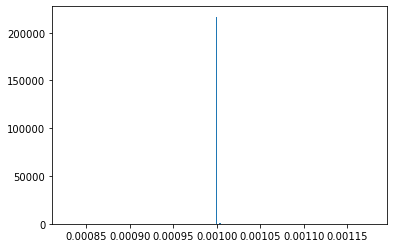

In [7]:
a = plt.hist(dt_array,500);

In [8]:
idx = np.argmax(a[0]== max(a[0]))
print('center of the highest bin = ', np.mean((a[1][idx], a[1][idx+1])))

center of the highest bin =  0.0009996538162231445


In [9]:
print(max(dt_array), min(dt_array))

0.0011785030364990234 0.0008285045623779297


In [10]:
np.median(dt_array)

0.0009999275207519531

#### We will simply take the sampling rate as 1kHz. This will not have any impact on the results.

In [11]:
nt = int(buffer_size/dt)
t = np.arange(nt)*dt

In [12]:
d = d[:nt] #cut the data to buffer_size
t = t[:nt]

In [13]:
ax = sum([np.array(d['%d X'%(i+1)]) for i in range(2)])/3.
ay = sum([np.array(d['%d Y'%(i+1)]) for i in range(2)])/3.
az = sum([np.array(d['%d Z'%(i+1)]) for i in range(2)])/3.
#1 is at +y, 2 at -x, 3 at +x, 120 deg apart
arx = -((np.array(d['2 Z'])+np.array(d['3 Z']))/2 - np.array(d['1 Z']))/(0.75*8.36)
ary = (np.array(d['2 Z'])-np.array(d['3 Z']))/(8.36/2*np.sqrt(3.0))

wave_freq1 = 30 #in Hertz
wave_freq2 = 230
scalef = 0.001 #%put it roughly same magnitude with real vibrations
#this can be ax_test, ay_test, az_test, arx_test, or ary_test
a_test = (np.sin(2*np.pi*wave_freq1*t) + 64 * np.sin(2*np.pi*wave_freq2*t))*scalef 

In [14]:
# If using data from Ed
#import os
#from scipy.io import loadmat
#filename = '%s/wavefront/activeoptics/matlab/m1m3/vibration/a010.mat'%os.environ['HOME']
#d = loadmat(filename)
# a1d = d['aa']
# t = d['t']

## From now on, work with piston (Piston is used as the example; simply switch to ax, ay, az, arx, ary for tip, tilt and rotation results)

In [15]:
dof = 0

dofName = ['piston', 'xdecenter', 'ydecenter', 'xtilt', 'ytilt']
dofArray = [az, ax, ay, arx, ary]
dofLim = [0.38, 0.23, 0.23, 1.0, 1.0]/np.sqrt(5.) #in micron or 1E-6 deg

a1d = dofArray[dof]
an = dofName[dof]

In [16]:
a1d = np.squeeze(a1d) #the 1d fft assumes there is only axis=0 for these vectors
t = np.squeeze(t)

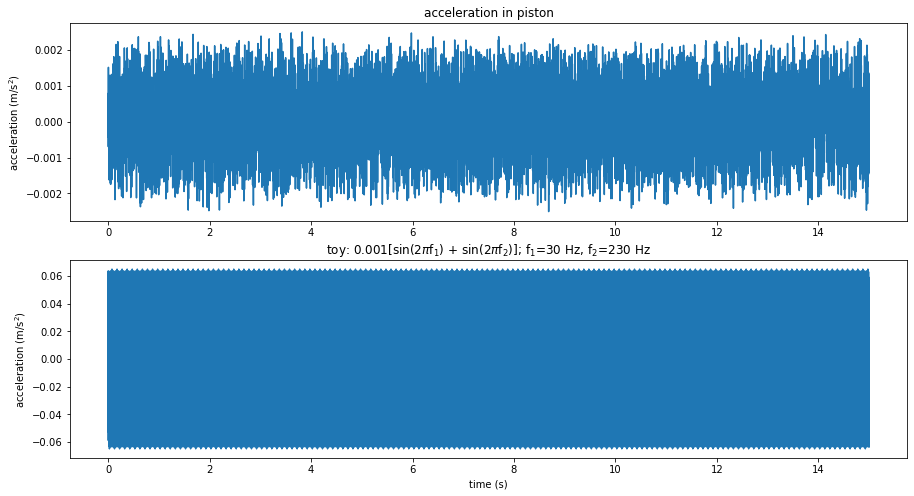

In [17]:
fig, axis = plt.subplots(2,1, figsize=(15,8))
axis[0].plot(t,a1d)
axis[0].set_ylabel('acceleration (m/s$^2$)')
axis[0].set_title('acceleration in %s'%an)
axis[1].plot(t, a_test)
axis[1].set_ylabel('acceleration (m/s$^2$)')
axis[1].set_title('toy: %.3f[sin(2$\pi$f$_1$) + sin(2$\pi$f$_2$)]; f$_1$=%.0f Hz, f$_2$=%.0f Hz'%(
    scalef, wave_freq1, wave_freq2))
axis[1].set_xlabel('time (s)');

### Do the double-integration to get displacements.

In [18]:
def acc2disp(datain, dt, datain_type, dataout_type,cutf):
    if (datain_type < 1 or datain_type > 3):
        print('Value for datain_type must be a 1, 2 or 3')
        return 0
    elif (dataout_type < 1 or dataout_type > 3):
        print('Value for dataout_type must be a 1, 2 or 3')
        return 0

    #   Determine Number of points (next power of 2), frequency increment
    #   and Nyquist frequency
    N0 = datain.shape[0]
    N = int(2**np.ceil(np.log(N0)/np.log(2)))
    df = 1./ (N * dt)
    Nyq = 1./ (2.*dt)
    
    #   Save frequency array
    f = np.linspace(-Nyq, Nyq-df, int(2* Nyq/df))
    iomega_array = 1j*2*np.pi*f
    iomega_exp = dataout_type - datain_type
    
    #   Pad datain array with zeros (if needed)
    aa = np.zeros(N)
    aa[:N0] = datain
    datain = aa
    
    #   Transform datain into frequency domain via FFT and shift output (A)
    #   so that zero-frequency amplitude is in the middle of the array
    #   (instead of the beginning)
    A = fftpack.fft(datain)
    A = fftpack.fftshift(A)
    A[abs(f)<cutf] = 0
    
    #   Convert datain of type datain_type to type dataout_type
    for j in range(N):
        if iomega_array[j] != 0:
            A[j] = A[j] * (iomega_array[j] ** iomega_exp)
        else:
            A[j] = 0+0j
    
    #   Shift new frequency-amplitude array back and
    #   transform back into the time domain via the inverse FFT.
    A = fftpack.ifftshift(A)
    datain = fftpack.ifft(A)
    
    #   Remove zeros that were added to datain in order to pad to next
    #   biggerst power of 2 and return dataout.
    dataout = np.real(datain[:N0])
    
    return dataout

In [19]:
#cutoff_frequency = 10
d1d = acc2disp(a1d, dt, 3, 1, cutoff_frequency)
d_test = acc2disp(a_test, dt, 3,1, cutoff_frequency)
d1d_f0 = acc2disp(a1d, dt, 3, 1, 0)
d_test_f0 = acc2disp(a_test, dt, 3,1, 0)

In [20]:
dtruth = -1./(2*np.pi*wave_freq1)**2*np.sin(2*np.pi*wave_freq1*t) \
         -1./(2*np.pi*wave_freq2)**2*np.sin(2*np.pi*wave_freq2*t)
dtruth = dtruth*scalef

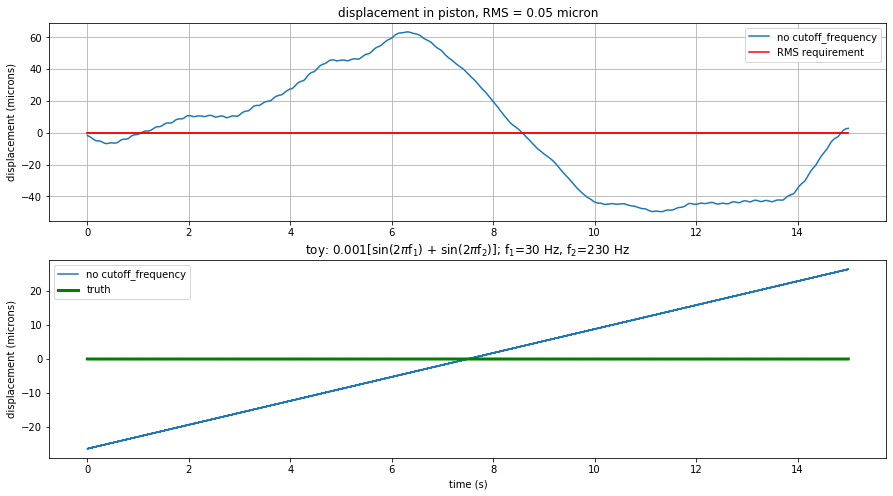

In [21]:
fig, axis = plt.subplots(2,1, figsize=(15,8))
axis[0].plot(t,d1d_f0*1e6, label='no cutoff_frequency')
axis[0].plot([t[0],t[-1]], [-dofLim[dof], -dofLim[dof]], 'r', label='RMS requirement')
axis[0].plot([t[0],t[-1]], [dofLim[dof], dofLim[dof]], 'r')
axis[0].set_ylabel('displacement (microns)')
axis[0].set_title('displacement in %s, RMS = %.2f micron'%(an, np.std(d1d)*1e6))
axis[0].grid()
axis[0].legend()
axis[1].plot(t, d_test_f0*1e6, label='no cutoff_frequency')
axis[1].plot(t, dtruth*1e6, 'g', linewidth = 3, label='truth')
axis[1].set_ylabel('displacement (microns)')
axis[1].set_title('toy: %.3f[sin(2$\pi$f$_1$) + sin(2$\pi$f$_2$)]; f$_1$=%.0f Hz, f$_2$=%.0f Hz'%(
    scalef, wave_freq1, wave_freq2))
axis[1].set_xlabel('time (s)')
axis[1].legend();

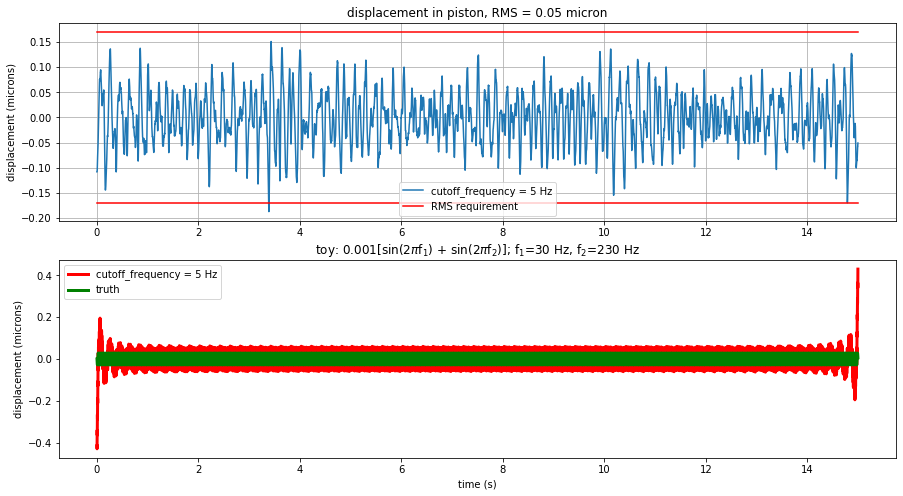

In [22]:
fig, axis = plt.subplots(2,1, figsize=(15,8))
axis[0].plot(t,d1d*1e6, label='cutoff_frequency = %.0f Hz'%cutoff_frequency)
#axis[0].plot(t,d1d_f0*1e6, label='no cutoff_frequency')
axis[0].plot([t[0],t[-1]], [-dofLim[dof], -dofLim[dof]], 'r', label='RMS requirement')
axis[0].plot([t[0],t[-1]], [dofLim[dof], dofLim[dof]], 'r')
axis[0].set_ylabel('displacement (microns)')
axis[0].set_title('displacement in %s, RMS = %.2f micron'%(an, np.std(d1d)*1e6))
axis[0].grid()
axis[0].legend()
axis[1].plot(t, d_test*1e6, 'r', linewidth=3, label='cutoff_frequency = %.0f Hz'%cutoff_frequency)
#axis[1].plot(t, d_test_f0*1e6, label='no cutoff_frequency')
axis[1].plot(t, dtruth*1e6, 'g', linewidth = 3, label='truth')
axis[1].set_ylabel('displacement (microns)')
axis[1].set_title('toy: %.3f[sin(2$\pi$f$_1$) + sin(2$\pi$f$_2$)]; f$_1$=%.0f Hz, f$_2$=%.0f Hz'%(
    scalef, wave_freq1, wave_freq2))
axis[1].set_xlabel('time (s)')
axis[1].legend();

### PSD of displacement

In [23]:
#calculate PSD
def psd1d(cx, dt):
    N = cx.shape[0]

    df = 1./ (N * dt)
    aa = abs( fftpack.fft(cx))**2 * dt/N   
    PSD = (aa[:int(N / 2)]) 
    PSD += (aa[-1:-int(N / 2)-1:-1])   #add negative frequencies
    f = df * np.arange(int(N / 2))

    cutoff = f>0 #discard zero frequency
    f = f[cutoff]
    PSD = PSD[cutoff] 

    return PSD, f

In [24]:
dpsd, f = psd1d(d1d, dt)
dtpsd, f = psd1d(d_test, dt)

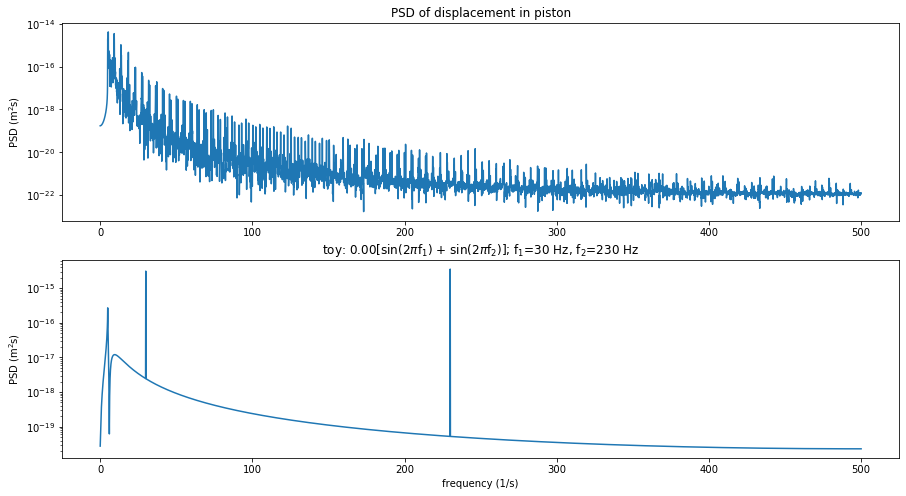

In [25]:
fig, axis = plt.subplots(2,1, figsize=(15,8))
axis[0].semilogy(f, dpsd)
axis[0].set_ylabel('PSD (m$^2$s)')
axis[0].set_title('PSD of displacement in %s'%an)
axis[1].semilogy(f, dtpsd)
axis[1].set_ylabel('PSD (m$^2$s)')
axis[1].set_title('toy: %.2f[sin(2$\pi$f$_1$) + sin(2$\pi$f$_2$)]; f$_1$=%.0f Hz, f$_2$=%.0f Hz'%(
    scalef, wave_freq1, wave_freq2))
axis[1].set_xlabel('frequency (1/s)');

In [26]:
a = dtpsd
idx = np.argmax(a>1e-17)
print(f[idx:idx+5])
#cutting low frequency abruptly created some artifacts, but not big enough to confuse our signal

[3.46666667 3.53333333 3.6        3.66666667 3.73333333]


### Cumulative PSD of displacement

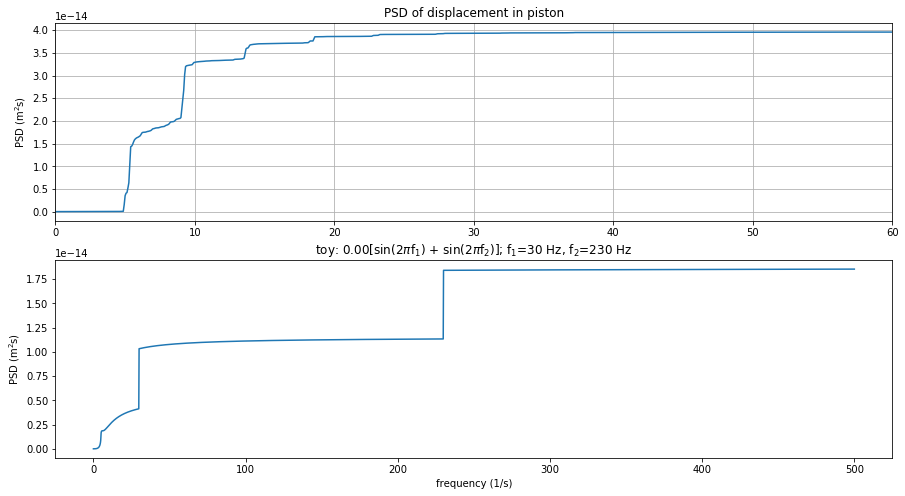

In [27]:
fig, axis = plt.subplots(2,1, figsize=(15,8))
axis[0].plot(f, np.cumsum(dpsd))
axis[0].set_ylabel('PSD (m$^2$s)')
axis[0].set_title('PSD of displacement in %s'%an)
axis[0].set_xlim([0, 60])
axis[0].grid()
axis[1].plot(f, np.cumsum(dtpsd))
axis[1].set_ylabel('PSD (m$^2$s)')
axis[1].set_title('toy: %.2f[sin(2$\pi$f$_1$) + sin(2$\pi$f$_2$)]; f$_1$=%.0f Hz, f$_2$=%.0f Hz'%(
    scalef, wave_freq1, wave_freq2))
#axis[1].set_ylim([5.85e-15, 6e-15])
axis[1].set_xlabel('frequency (1/s)');

### Convert displacement into Image Size

* M1M3

The jira LVV ticket is https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T315

Sensitivities can be found here https://docushare.lsstcorp.org/docushare/dsweb/Get/Document-7271/

IQ repo: https://github.com/bxin/ImageQuality/tree/master/leafNodes/TLS/M1M3/vibration

The LTS-88 motion requirements (`dofLim` above = https://jira.lsstcorp.org/browse/LVV-11306) correponds to 10 mas.

* M2

Sensitivities can be found from the AOS sensitivity matrix.

* Camera

https://github.com/bxin/ImageQuality/tree/master/leafNodes/Cam/CamVibration

Sensitivities can be found from the AOS sensitivity matrix.

In [28]:
sensitivity = [10./0.38, 10./0.23, 10./0.23, 10./1., 10./1.] #mas per micron or mas per 1E-6 degree

Total IQ degradation: 3.5 mas


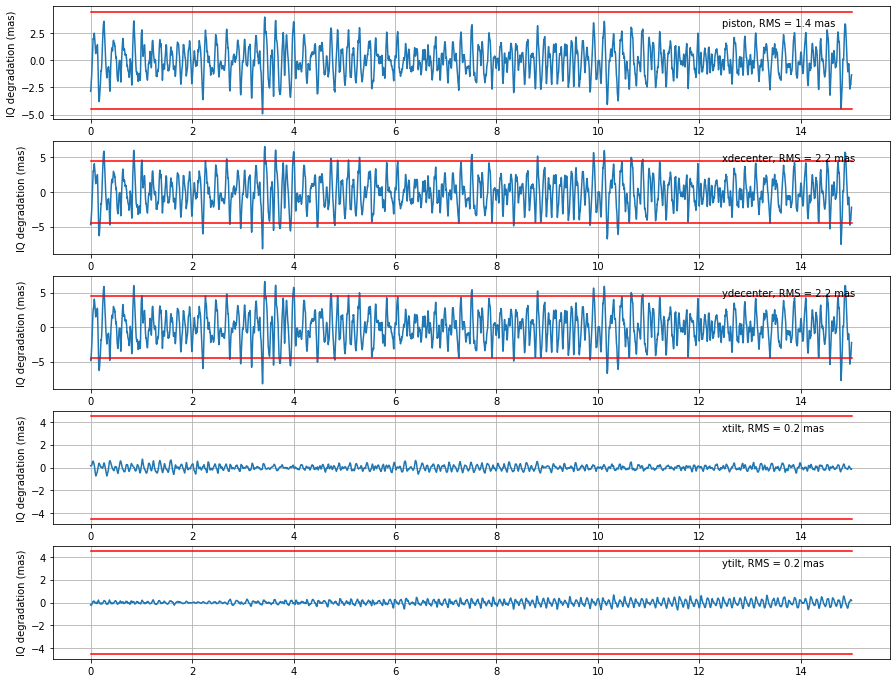

In [29]:
fig, axis = plt.subplots(5,1, figsize=(15,12))
total_rms = 0
for dof in range(5):
    a1d = np.squeeze(dofArray[dof])
    an = dofName[dof]

    #axis[dof].plot(t,a1d*1e6, label='cutoff_frequency = %.0f Hz'%cutoff_frequency)
    
    d1d = acc2disp(a1d, dt, 3, 1, cutoff_frequency)
    #print(max(d1d))
    axis[dof].plot(t,d1d*1e6*sensitivity[dof], label='cutoff_frequency = %.0f Hz'%cutoff_frequency)

    axis[dof].plot([t[0],t[-1]], [-dofLim[dof]*sensitivity[dof], -dofLim[dof]*sensitivity[dof]], 'r', 
                   label='RMS requirement')
    axis[dof].plot([t[0],t[-1]], [dofLim[dof]*sensitivity[dof], dofLim[dof]*sensitivity[dof]], 'r')
    axis[dof].set_ylabel('IQ degradation (mas)')
    axis[dof].text(0.8, 0.82, '%s, RMS = %.1f mas'%(an, np.std(d1d)*1e6*sensitivity[dof]), 
                   color = 'black', transform=axis[dof].transAxes)
    axis[dof].grid()
    #axis[dof].legend()
    
    total_rms += (np.std(d1d)*1e6*sensitivity[dof])**2
total_rms = np.sqrt(total_rms)
print('Total IQ degradation: %.1f mas'%total_rms)